# Pião de Euler
* Trabalho de Mecânica II
* Aluno: Raphael Pereira Rolim e Silva
* N.USP: 12610413

## Dependências

In [39]:
import numpy as np
from numpy import sin, cos, pi
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.style.use('fivethirtyeight')



## O Problema


O Pião de Euler é um corpo rígido rotacionando em um campo gravitacional constante com um ponto fixo. São duas forças atuando no pião:
1. A força gravitacional constante atuando no centro de massa;
2. A força de reação atuando no ponto fixo.

Este problema é muito utilizado na solução de equações diferenciais e sua relação com a conservação de grandezas físicas. Sendo assim, a ideia deste trabalho é resolver as equações de movimento do pião, verificar a conservação das velocidades angulares $\dot{\phi}$ e $\dot{\psi}$ e criar uma animação 2D para seu movimento. Podemos também testar alguns valores diferentes para a gravidade e verificar o efeito sobre o pião a partir da mudança dessa grandeza.

![Pião de Euler](spinning_top.png)

A figura acima representa um pião simétrico com massa $m$ e que está fixo em $O$. A parametrização do movimento do pião irá envolver 3 rotações em 3 eixos diferentes:

1. Em torno do eixo $Z \equiv z_1$, com velocidade angular $\dot{\psi}$ e ângulo de _spin_ $\psi$;
2. Em torno de $x_1 \equiv x_2$ no sentido positivo, com velocidade angular $\dot{\theta}$ e ângulo de nutação $\theta$;
3. Em torno de $z_2 \equiv z$, com velocidade angular $\dot{\phi}$ com ângulo de precessão $\phi$.

O Centro de Massa (CM) do pião fica no ponto $A$ e a distância $A\to O$ é $\ell$.

A lagrangiana do problema é dada por:

$$
\mathcal{L} = K - V,
$$
onde $K$ é a energia cinética e $V$ é a energia potencial. A energia cinética pode ser descrita como

$$
K = \frac{1}{2} \omega^T I \omega,
$$
onde $\omega$ é a velocidade angular do pião e $I$ é o tensor de inércia, que pode ser decomposto pelos tensores de inércia dos eixos $x_2$, $y_2$ e $z_2$

$$
I = 
\begin{pmatrix}
I_{x_2} + m\ell^2 & 0 & 0 \\
0 & I_{y_2} + m\ell^2 & 0 \\
0 & 0 & I_{z_2}
\end{pmatrix} =
\begin{pmatrix}
I & 0 & 0 \\
0 & I & 0 \\
0 & 0 & I_{z_2}
\end{pmatrix}
$$

Como o pião é isotrópico, podemos considerar que $I_{x_2} = I_{y_2}$, então $I = I_{x_2} + m\ell^2$.

A energia potencial pode ser descrita como

$$
V = mg\ell\cos\theta,
$$

onde $g$ é a aceleração gravitacional. Utilizando as equações de Euler-Lagrange, encontramos:

$$
\begin{dcases}
\frac{\partial \mathcal{L}}{\partial \dot{\phi}} = \dot{\phi} \left( I \sin^2\theta + I_{z_2} \cos^2\theta \right) + I_{z_2}\dot{\psi}\cos\theta = p_\phi \\
\frac{\partial \mathcal{L}}{\partial \dot{\psi}} = I_{z_2} \left( \dot{\psi} + \dot{\phi}\cos\theta \right) = p_\psi \\
I \ddot{\theta} - \dot{\phi}^2 \sin\theta\cos\theta (I-I_{z_2}) + \dot{\phi}\dot{\psi}I_{z_2}\sin\theta - mg\ell\sin\theta = 0
\end{dcases}
$$

Considerando o pião com massa $m = 0.5$ kg, raio $r = 0.2$ m, $\ell = 0.4$ m e definindo a gravidade para $g = 9.8$ m/s², temos:

In [40]:
m = 0.5
r = 0.2
l = 0.4
g = 9.8

Vamos definir uma função para calcular as EDOs. A função toma como parâmetros o tempo atual $t$, o vetor estado atual $y = (\phi, \psi, \theta, \dot{\theta})$, o _spin_ inicial, que é padronizado para 500 rad/s e o ângulo de nutação inicial $\theta_0$, padronizado para $\pi/6$. A função retorna o vetor derivada de estado $\dot{y} = (\dot{\phi}, \dot{\psi}, \dot{\theta}, \ddot{\theta})$.

In [41]:
def ode_solver(t, y, spin=500, theta0=np.pi/6):
    I = (1/4) * m * r ** 2 + m * l ** 2
    I_z2 = (1/2) * m * r ** 2
    dy = np.zeros(y.shape)

    Pphi = I_z2 * spin * np.cos(theta0)
    Ppsi = I_z2 * spin
    
    DP = (I * np.sin(y[2]) ** 2 + I_z2 * np.cos(y[2]) ** 2) * I_z2 - I_z2 ** 2 * np.cos(y[2]) ** 2

    if spin > 0.001:
        # Se o spin ~ 0, então a conservação das equações de momento angular são singulares e devem ser substituídas por 0
        dy[0] = (I_z2 * Pphi - I_z2 * np.cos(y[2]) * Ppsi) / DP
        dy[1] = (-I_z2 * np.cos(y[2]) * Pphi + (I * np.sin(y[2]) ** 2 + I_z2 * np.cos(y[2]) ** 2) * Ppsi) / DP
    
    dy[2] = y[3]
    dy[3] = dy[0] ** 2 * np.sin(y[2]) * np.cos(y[2]) * (I-I_z2) - dy[0] * dy[1] * I_z2 * np.sin(y[2]) + m * g * l * np.sin(y[2])
    dy[3] = dy[3] / I

    return dy

## Solução


Se $\dot{\psi} >> \dot{\theta}, \dot{\phi}, \ddot{\theta}$, então as equações se simplificam para uma relação entre $\dot{\psi}$ e $\dot{\phi}$:

$$
\dot{\phi} = \frac{mg\ell}{I_{z_2}\dot{\psi}}.
$$

Utilizando o período $T = 2\pi/\dot{\phi}$ como uma solução para um intervalo [0,T], temos:

In [42]:
I_z2 = (1/2) * m * r ** 2
theta0 = np.pi/6
spin = 500

T = 2 * np.pi * I_z2 * spin/(m * g * l)

res = solve_ivp(lambda t, y: ode_solver(t, y),
                [0,T],
                np.array([0, 0, theta0, 0]),
                t_eval=np.linspace(0, T, 10 ** 3))

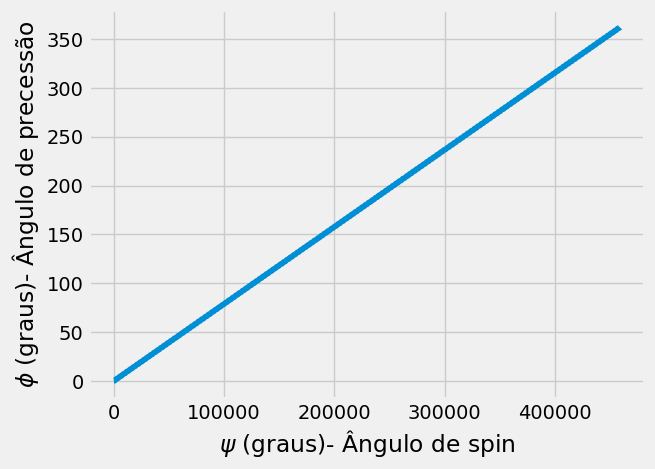

In [43]:
plt.plot(res.y[1]*180/pi, res.y[0]*180/pi)
plt.xlabel(r'$\psi$ (graus)- Ângulo de spin')
plt.ylabel(r'$\phi$ (graus)- Ângulo de precessão');
plt.show()

Observamos que de fato, $\dot{\phi}$ e $\dot{\psi}$ são constantes, já que observamos uma reta para um $\dot{\psi}$ muito grande. Podemos também plotar as posições em cada eixo, onde deveríamos ver $x$ e $y$ como funções periódicas/senoidais e o eixo $z$ como constante, por estar fixo.

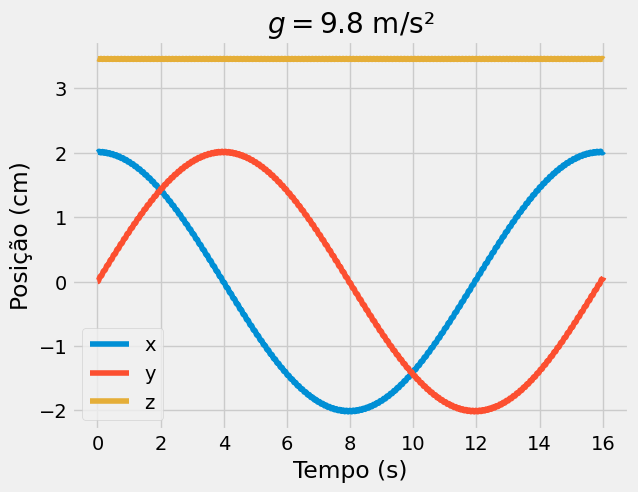

In [44]:
x = l*np.sin(res.y[2])*np.cos(res.y[0])
y = l*np.sin(res.y[2])*np.sin(res.y[0])
z = l*np.cos(res.y[2])

plt.plot(res.t, 10*x, label = 'x')
plt.plot(res.t, 10*y, label = 'y')
plt.plot(res.t, 10*z, label = 'z')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (cm)')
plt.title(r'$g=9.8$ m/s²')
plt.legend();

A movimentação do pião está de acordo com o esperado. Agora, podemos animar o movimento do pião:

In [45]:
fig, ax = plt.subplots()
line, = ax.plot(x, y)
marker, = ax.plot([], [], '+', markersize=30)
S = max(x) * 1.1
ax.set(xlim=(-S, S))
ax.set_aspect('equal')
ax.set_xlabel('Posição no eixo x (m)')
ax.set_ylabel('Posição no eixo y (m)')
ax.set_title(r'Movimento do Pião ($g=9.8$ m/s²)')

fig.tight_layout()

plt.close()

def init():
    line.set_data([], [])
    marker.set_data([], [])
    return line, marker

def animate(i):
    line.set_data(x[:i], y[:i])
    marker.set_data(x[i], y[i])
    return line, marker

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(len(x)), interval=10, 
                               blit=True)

# Use PillowWriter to save the animation as a GIF
#writer = animation.PillowWriter(fps=30)
#anim.save("g_98.gif", writer=writer)

HTML(anim.to_html5_video())

/tmp/ipykernel_35588/2504634235.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])
/tmp/ipykernel_35588/2504634235.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])


## Variação da gravidade

Vamos agora experimentar alguns valores diferentes para a gravidade.

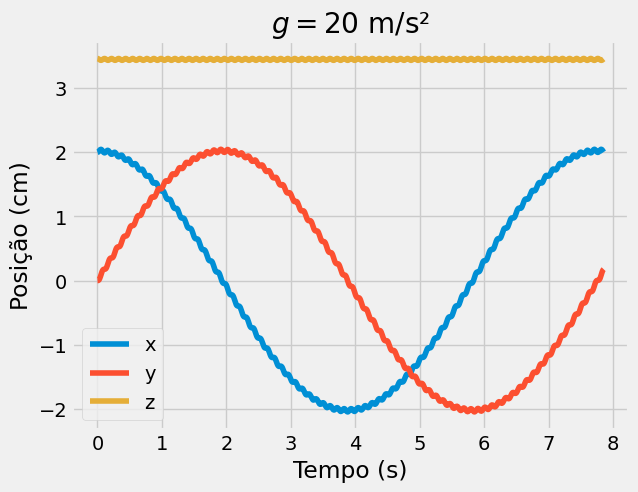

In [46]:
g = 20

I_z2 = (1/2) * m * r ** 2
theta0 = np.pi/6
spin = 500

T = 2 * np.pi * I_z2 * spin/(m * g * l)

res = solve_ivp(lambda t, y: ode_solver(t, y),
                [0,T],
                np.array([0, 0, theta0, 0]),
                t_eval=np.linspace(0, T, 10 ** 3))

x = l*np.sin(res.y[2])*np.cos(res.y[0])
y = l*np.sin(res.y[2])*np.sin(res.y[0])
z = l*np.cos(res.y[2])

plt.plot(res.t, 10*x, label = 'x')
plt.plot(res.t, 10*y, label = 'y')
plt.plot(res.t, 10*z, label = 'z')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (cm)')
plt.title(r'$g=20$ m/s²')
plt.legend();

In [47]:
fig, ax = plt.subplots()
line, = ax.plot(x, y)
marker, = ax.plot([], [], '+', markersize=30)
S = max(x) * 1.1
ax.set(xlim=(-S, S))
ax.set_aspect('equal')
ax.set_xlabel('Posição no eixo x (m)')
ax.set_ylabel('Posição no eixo y (m)')
ax.set_title(r'Movimento do Pião ($g=20$ m/s²)')

fig.tight_layout()

plt.close()

def init():
    line.set_data([], [])
    marker.set_data([], [])
    return line, marker

def animate(i):
    line.set_data(x[:i], y[:i])
    marker.set_data(x[i], y[i])
    return line, marker

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(len(x)), interval=10, 
                               blit=True)

# Use PillowWriter to save the animation as a GIF
#writer = animation.PillowWriter(fps=30)
#anim.save("g_20.gif", writer=writer)

HTML(anim.to_html5_video())

/tmp/ipykernel_35588/2462713266.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])
/tmp/ipykernel_35588/2462713266.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])


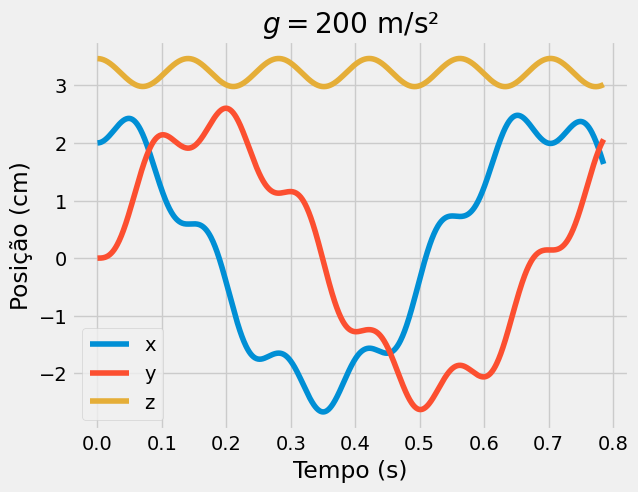

In [48]:
g = 200

I_z2 = (1/2) * m * r ** 2
theta0 = np.pi/6
spin = 500

T = 2 * np.pi * I_z2 * spin/(m * g * l)

res = solve_ivp(lambda t, y: ode_solver(t, y),
                [0,T],
                np.array([0, 0, theta0, 0]),
                t_eval=np.linspace(0, T, 10 ** 3))

x = l*np.sin(res.y[2])*np.cos(res.y[0])
y = l*np.sin(res.y[2])*np.sin(res.y[0])
z = l*np.cos(res.y[2])

plt.plot(res.t, 10*x, label = 'x')
plt.plot(res.t, 10*y, label = 'y')
plt.plot(res.t, 10*z, label = 'z')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (cm)')
plt.title(r'$g=200$ m/s²')
plt.legend();

In [49]:
fig, ax = plt.subplots()
line, = ax.plot(x, y)
marker, = ax.plot([], [], '+', markersize=30)
S = max(x) * 1.1
ax.set(xlim=(-S, S))
ax.set_aspect('equal')
ax.set_xlabel('Posição no eixo x (m)')
ax.set_ylabel('Posição no eixo y (m)')
ax.set_title(r'Movimento do Pião ($g=200$ m/s²)')

fig.tight_layout()

plt.close()

def init():
    line.set_data([], [])
    marker.set_data([], [])
    return line, marker

def animate(i):
    line.set_data(x[:i], y[:i])
    marker.set_data(x[i], y[i])
    return line, marker

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(len(x)), interval=10, 
                               blit=True)

# Use PillowWriter to save the animation as a GIF
#writer = animation.PillowWriter(fps=30)
#anim.save("g_200.gif", writer=writer)

HTML(anim.to_html5_video())

/tmp/ipykernel_35588/603441714.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])
/tmp/ipykernel_35588/603441714.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])


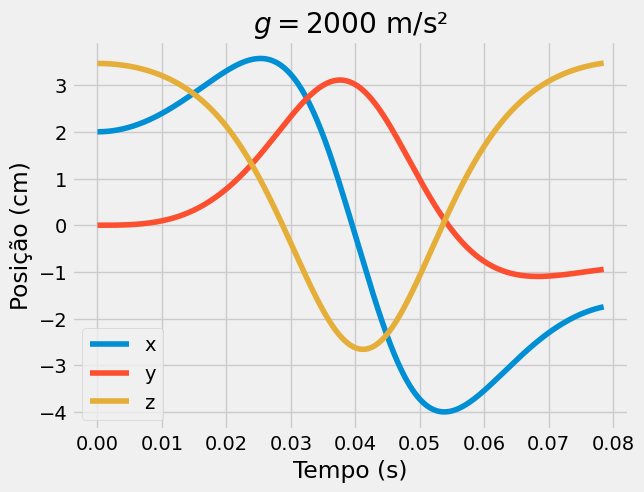

In [50]:
g = 2000

I_z2 = (1/2) * m * r ** 2
theta0 = np.pi/6
spin = 500

T = 2 * np.pi * I_z2 * spin/(m * g * l)

res = solve_ivp(lambda t, y: ode_solver(t, y),
                [0,T],
                np.array([0, 0, theta0, 0]),
                t_eval=np.linspace(0, T, 10 ** 3))

x = l*np.sin(res.y[2])*np.cos(res.y[0])
y = l*np.sin(res.y[2])*np.sin(res.y[0])
z = l*np.cos(res.y[2])

plt.plot(res.t, 10*x, label = 'x')
plt.plot(res.t, 10*y, label = 'y')
plt.plot(res.t, 10*z, label = 'z')
plt.xlabel('Tempo (s)')
plt.ylabel('Posição (cm)')
plt.title(r'$g=2000$ m/s²')
plt.legend();

In [51]:
fig, ax = plt.subplots()
line, = ax.plot(x, y)
marker, = ax.plot([], [], '+', markersize=30)
S = max(x) * 1.1
ax.set(xlim=(-S, S))
ax.set_aspect('equal')
ax.set_xlabel('Posição no eixo x (m)')
ax.set_ylabel('Posição no eixo y (m)')
ax.set_title(r'Movimento do Pião ($g=2000$ m/s²)')

fig.tight_layout()

plt.close()

def init():
    line.set_data([], [])
    marker.set_data([], [])
    return line, marker

def animate(i):
    line.set_data(x[:i], y[:i])
    marker.set_data(x[i], y[i])
    return line, marker

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(len(x)), interval=10, 
                               blit=True)

# Use PillowWriter to save the animation as a GIF
#writer = animation.PillowWriter(fps=30)
#anim.save("g_2000.gif", writer=writer)

HTML(anim.to_html5_video())

/tmp/ipykernel_35588/495836985.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])
/tmp/ipykernel_35588/495836985.py:22: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  marker.set_data(x[i], y[i])


Podemos notar que a cada aumento de gravidade, a precessão do pião parece se tornar cada vez maior, o que é esperado já que quando um pião está girando, a gravidade exerce um torque sobre ele, o que faz com que o momento angular mude de direção. A taxa de mudança do momento angular $\frac{\text{d}\mathbf{L}}{\text{d}t} = \boldsymbol{\tau}$.

O torque pode ser escrito como
$$
\boldsymbol{\tau} = \mathbf{r} \times m \mathbf{g} \to \tau = r \cdot m \cdot g
$$

Podemos definir uma taxa de precessão
$$
\Omega_\text{p} = \frac{\tau}{L} = \frac{r\cdot m\cdot g}{L}.
$$

Ou seja, conforme a gravidade aumenta, a precessão aumenta junto, o que faz que o eixo de rotação do pião mude de direção mais rapidamente.

## Conclusão

De acordo com o progresso do trabalho, foi possível investigar os atributos da conservação de grandezas (das velocidades angulares) do problema a partir da solução de EDOs e também animar o Pião de Euler. Fora isso, também observamos com sucesso a precessão do pião aumentar conforme a gravidade aumenta.

## Bibliografia

[1]. Cláudio H. C. Costa Basquerotto, Edison Righetto, e Samuel da Silva. As simetrias de lie de um pião. Revista Brasileira de Ensino de Física, 40, 11 2017.

[2]. William B. Heard. Rigid Body Mechanics. Wiley, 10 2005.

[3]. [Ryan C. Cooper Advanced Mechanics Lectures](https://cooperrc.github.io/advanced-dynamics/intro.html)